**Welcome to Assignment 3 on Deep Learning for Computer Vision.**

This assignment is based on the content you learned in Week-5 of course.


#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

##MNIST classification using CNN

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines.
torch.manual_seed(2024)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2024)

### Data Loading and Pre-processing

In [2]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#### YOUR CODE ENDS HERE ####

# Hyper parameters
num_epochs = 10
num_classes = 10
learning_rate = 0.001

# define a transforms for preparing the dataset
# for normalization of the MNIST dataset, take mean=0.1307 and std=0.3081

#### YOUR CODE STARTS HERE ####
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])
#### YOUR CODE ENDS HERE ####

In [3]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
#### YOUR CODE ENDS HERE ####

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4372438.43it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 124589.18it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:26<00:00, 62456.18it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1565625.31it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
import torch.utils.data as data
import torchvision.datasets as datasets
batch_size = 32

train_dataloader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#### YOUR CODE ENDS HERE ####


### Network Definition

In [5]:
# Convolutional neural network (Two convolutional layers)
class ConvolutionNet(nn.Module):
    def __init__(self, num_classes=10):
        super( ConvolutionNet, self).__init__()

        # define a sequential module with
        # 1. conv layer with input channel as 1, output channels as 32, kernel size of 5, stride of 1 and padding 2
        # 2. 2D BatchNorm of 32 features
        # 3. ReLU activation
        # 4. 2D MaxPool with kernel size of 2 and stride of 2

        #### YOUR CODE STARTS HERE ####
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        #### YOUR CODE ENDS HERE ####

        # define a sequential module with
        # 1. conv layer with input channel as 32, output channels as 16, kernel size of 7, stride of 1 and padding 3
        # 2. 2D BatchNorm of 16 features
        # 3. ReLU activation
        # 4. 2D MaxPool with kernel size of 2 and stride of 2

        #### YOUR CODE STARTS HERE ####
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        #### YOUR CODE ENDS HERE ####

        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset

        #### YOUR CODE STARTS HERE ####
        self.fc = nn.Linear(in_features=16*7*7, out_features=num_classes)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the sequential convolution blocks defined above (conv_block1--> conv_block2-->fc) and
        # write the forward pass.

        #### YOUR CODE STARTS HERE ####
        output = self.conv_block1(x)
        output = self.conv_block2(output)

        # Reshape appropiately
        output = output.view(output.size(0), -1)

        output = self.fc(output)
        #### YOUR CODE ENDS HERE ####
        return output


In [6]:
model = ConvolutionNet(num_classes).to(device)
model.conv_block2[0].weight.shape

torch.Size([16, 32, 7, 7])

### Question 1

What is the size of parameter matrix corresponding to convolution layer of second sequential block ?

1. 32x16x5x5
2. 32x32x6x6
3. 16x32x7x7
4. 32x16x4x4


### Training and Inference

In [7]:
#define the model
#### YOUR CODE STARTS HERE ####
model = ConvolutionNet(num_classes=num_classes).to(device)
#### YOUR CODE ENDS HERE ####


#define cross entropy loss and Adam optimizer using learning rate=learning_rate
#### YOUR CODE STARTS HERE ####
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#### YOUR CODE ENDS HERE ####

# Train the model
total_step = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
       #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        images = images.to(device)
        labels = labels.to(device)

        # flush out the gradients stored in optimizer
        optimizer.zero_grad()

        # pass the image to the model and assign the output to variable named output
        output = model(images)

        # calculate the loss (use cross entropy in pytorch)
        loss = criterion(output, labels)

        # do a backward pass
        loss.backward()

        # update the weights
        optimizer.step()
       #### YOUR CODE ENDS HERE ####
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
      ### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        images = images.to(device)
        labels = labels.to(device)
        # pass the image to the model and assign the output to variable named output
        outputs = model(images)
      #### YOUR CODE ENDS HERE ####
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model : {} %'.format(100 * correct / total))

Epoch [1/10], Step [100/1875], Loss: 0.1832
Epoch [1/10], Step [200/1875], Loss: 0.2194
Epoch [1/10], Step [300/1875], Loss: 0.1779
Epoch [1/10], Step [400/1875], Loss: 0.1004
Epoch [1/10], Step [500/1875], Loss: 0.0846
Epoch [1/10], Step [600/1875], Loss: 0.0332
Epoch [1/10], Step [700/1875], Loss: 0.0544
Epoch [1/10], Step [800/1875], Loss: 0.1384
Epoch [1/10], Step [900/1875], Loss: 0.0700
Epoch [1/10], Step [1000/1875], Loss: 0.0105
Epoch [1/10], Step [1100/1875], Loss: 0.0053
Epoch [1/10], Step [1200/1875], Loss: 0.0041
Epoch [1/10], Step [1300/1875], Loss: 0.0192
Epoch [1/10], Step [1400/1875], Loss: 0.0179
Epoch [1/10], Step [1500/1875], Loss: 0.0024
Epoch [1/10], Step [1600/1875], Loss: 0.0073
Epoch [1/10], Step [1700/1875], Loss: 0.0051
Epoch [1/10], Step [1800/1875], Loss: 0.0076
Epoch [2/10], Step [100/1875], Loss: 0.0201
Epoch [2/10], Step [200/1875], Loss: 0.0050
Epoch [2/10], Step [300/1875], Loss: 0.0087
Epoch [2/10], Step [400/1875], Loss: 0.0080
Epoch [2/10], Step [500

#### Question-2

Report the final test accuracy displayed above (If you are not getting the exact number shown in options, please report the closest number).
1. 84%
2. 76%
3. 99%
4. 57%


#### Question-3

Report the loss value at the step 1800? (If you are not getting the exact number shown in options, please report the closest number).
1. 0.0042
2. 0.15
3. 0.00065
4. 1.4


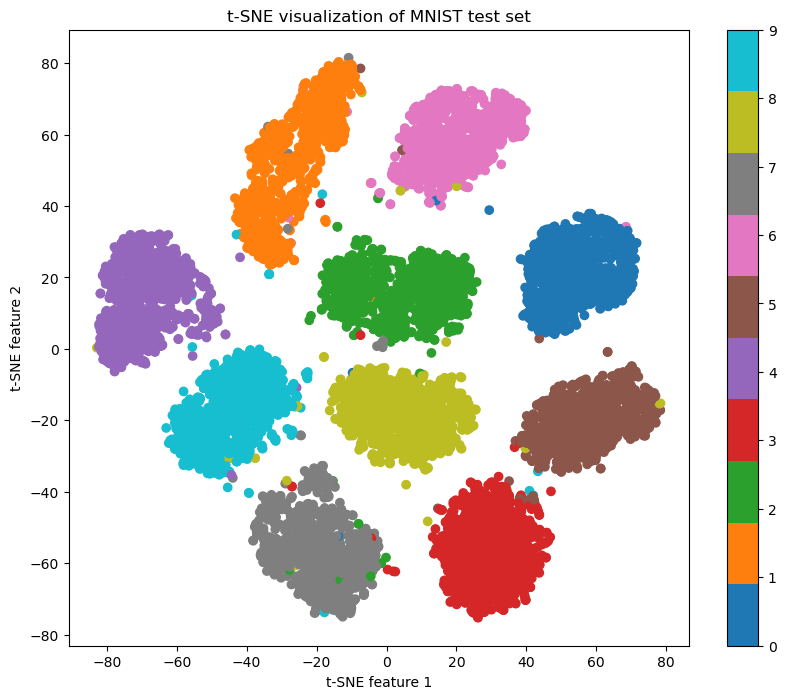

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create a Function to get embeddings
def get_embeddings(model, dataloader, device):
    # YOUR CODE STARTS HERE
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in dataloader:
            #Send images to GPU
            images = images.to(device)
            # Get the output of the second-to-last layer (before the final fully connected layer)
            output = model.conv_block1(images)
            output = model.conv_block2(output)
            # Flatten the embedding
            embedding = output.view(output.size(0), -1).cpu().numpy()
            # Append the embedding and labels to the lists
            embeddings.append(embedding)
            labels.append(batch_labels.numpy())

    #YOUR CODE ENDS HERE
    return np.vstack(embeddings), np.concatenate(labels)

# Get embeddings for the test set
test_embeddings, test_labels = get_embeddings(model, test_dataloader, device)

# Apply t-SNE

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(test_embeddings)

# Visualize the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=test_labels, cmap='tab10')
plt.colorbar(scatter)
plt.title('t-SNE visualization of MNIST test set')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

#### Question-4

Embedding of which class/digit is closest to the embedding of 7?
1. 3
2. 5
3. 8
4. 1


#### Question-5

Embedding of which class/digit is farthest to the embedding of 4?
1. 1
2. 6
3. 9
4. 3


shape of the filters is: (32, 1, 5, 5)


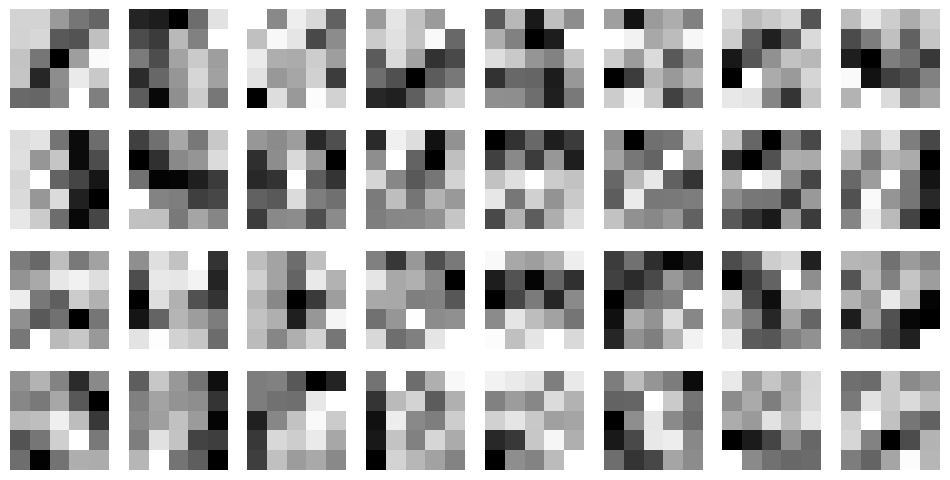

In [9]:
import matplotlib.pyplot as plt

# Get the weights of the first convolutional layer
#YOUR CODE STARTS HERE
filters = model.conv_block1[0].weight.data.cpu().numpy()
#YOUR CODE ENDS HERE

print(f"shape of the filters is: {filters.shape}")

# Normalize the filters for better visualization
min_val = filters.min()
max_val = filters.max()
filters = (filters - min_val) / (max_val - min_val)

# Plot the filters
fig, axes = plt.subplots(4, 8, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    if i < filters.shape[0]:
        # Each filter is in the shape of (out_channels, in_channels, height, width)
        # We take the first in_channel (0) since it's grayscale, so only one channel exists
        ax.imshow(filters[i, 0, :, :], cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()


#### Question-6

What is the shape of filters?
1. (32,16 , 5, 5)
2. (32, 1, 5, 5)
3. (16, 32, 5, 5)
4. (16, 1)
